# Auto Encoder (AE) and Variational Auto Encoder (VAE)
In this exercise auto encoder architecture will be discussed. Two variants of VAE will be implemened using Gaussian and Bernoulli priors. Finally, an example will be made how to use deterministic AE model as a generative model.

## Imports

In [1]:
import math
from typing import List, Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## Loading MNIST Dataset

MNIST dataset composed of handwritten digits will be used in this exercise. First, let's load the dataset and split it into training and development sets.

In [2]:
# download and load the dataset
mnist = torchvision.datasets.MNIST(root="/tmp", download=True, train=True)
data, classes = mnist.data / 255, mnist.targets

# binarize the input data. It's going to be modelled as Bernoulli RV.
data = (data > 0.5).float()

# train / Dev data split
split = int(0.8 * len(data))
train_data_pixels, train_data_classes = data[:split], classes[:split]
dev_data_pixels, dev_data_classes = data[split:], classes[split:]

train_data_pixels = train_data_pixels.reshape(len(train_data_pixels), 28*28)
dev_data_pixels = dev_data_pixels.reshape(len(dev_data_pixels), 28*28)

## Simple Auto-Encoder
We will start with defining a simple Auto-Encoder network for comparison and to present the base auto-encoder aritecture that lies underneath of Variational Auto-Encoder network.

Having a dataset $x^{(1)}, ..., x^{(N)}$, define encoder as $f_{\phi}$ and decoder $g_{\theta}$ where $\phi, \theta$ are trainable model parameters. Encoder transforms the input sample into latent space vector $$z = f_{\phi}(x),$$ while decoder translates latent vector into a vector from the dataset space $$\hat{x} = g_{\theta}(z).$$

Model training is realized with the objective of minimising reconstruction error, for examle MSE in this case:
$$
E = \frac{1}{N}\sum_{i=1}^{N}\left(x^{(i)} - \hat{x}^{(i)}\right)^2,
$$
and updating model parameters $\theta$, $\phi$ using gradients of $E$. 

In [3]:
def get_funnel(input_size: int, output_size: int) -> List[int]:
    """Generate layer sizes for funnel-like network
    where consecutive layers' sizes are powers of 2.
    """
    start = math.ceil(math.log2(input_size)) - 1
    stop = math.floor(math.log2(output_size))
    return [2**i for i in range(start, stop, -1)]


def build_model(
    layer_sizes: int, dropout: Optional[float] = None,
) -> nn.Sequential:
    """Translates an array of integer numbers into 
    a feed-forward network with relu activations.
    """
    if len(layer_sizes) < 3:
        return nn.Linear(layer_sizes[0], layer_sizes[1])

    layers = []
    for i in range(1, len(layer_sizes)-1):
        layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        layers.append(nn.ReLU())
        if dropout is not None:
            layers.append(nn.Dropout(dropout))
    layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

    return nn.Sequential(*layers)

In [4]:
class DeterministicEncoder(nn.Module):

    def __init__(
        self, 
        input_size: int, 
        latent_size: int, 
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Deterministic Encoder models mapping from the dataset space 
        into the latent vector space.
        
        Parameters:
        -----------
        input_size:
            Size of the input layer.
        latent_size:
            Size of the output vector.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        super(DeterministicEncoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(input_size, latent_size)
            
        # Translate layer sizes into nn.Sequential model.
        layers = [input_size] + hidden_sizes + [latent_size]
        
        self.network: nn.Sequential = build_model(layers, dropout=0.4)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        return self.network(X)
    

class DeterministicDecoder(nn.Module):
    
    def __init__(
        self, 
        output_size: int,
        latent_size: int,
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Deterministic Decoder learns a mapping from the latent 
        space into the dataset space.
        
        Parameters:
        -----------
        output_size:
            Size of the output vector.
        latent_size:
            Size of the input layer.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        
        super(DeterministicDecoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(output_size, latent_size)[::-1]
            
        # Translate layer sizes into nn.Sequential model.
        layers = [latent_size] + hidden_sizes + [output_size]
        self.network = build_model(layers, dropout=0.4)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        return self.network(X)

In [5]:
# Model hyperparameters.
input_dim = 28*28
latent_dim = 32
hidden_dims = [512, 256, 128]

# Training parameters.
n_epoch = 20
batch_dim = 256

encoder = DeterministicEncoder(input_dim, latent_dim, hidden_dims)
decoder = DeterministicDecoder(input_dim, latent_dim, hidden_dims[::-1])

# Adam optimizer, initialized with Encoder and Decoder parameters.
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4,
)

encoder.train()
decoder.train()
for epoch in range(n_epoch):
    epoch_loss = 0
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        # Take a slice of the data samples.
        batch = train_data_pixels[i:i+batch_dim]

        optimizer.zero_grad()
        # Make pass through the network.
        encoded = encoder(batch)
        output = decoder(encoded)
        # Compute reconstruction loss.
        loss = F.mse_loss(output, batch)
        epoch_loss += loss.item()
        # Update model parameters.
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} loss: {epoch_loss:.4f} ...")

Epoch 0 loss: 18.1768 ...
Epoch 1 loss: 15.9036 ...
Epoch 2 loss: 15.2663 ...
Epoch 3 loss: 14.6456 ...
Epoch 4 loss: 13.8970 ...
Epoch 5 loss: 13.2824 ...
Epoch 6 loss: 12.7848 ...
Epoch 7 loss: 12.4396 ...
Epoch 8 loss: 12.1783 ...
Epoch 9 loss: 11.9739 ...
Epoch 10 loss: 11.7866 ...
Epoch 11 loss: 11.6230 ...
Epoch 12 loss: 11.4960 ...
Epoch 13 loss: 11.3761 ...
Epoch 14 loss: 11.2650 ...
Epoch 15 loss: 11.1674 ...
Epoch 16 loss: 11.0868 ...
Epoch 17 loss: 11.0106 ...
Epoch 18 loss: 10.9376 ...
Epoch 19 loss: 10.8614 ...


### Check reconstruction results

Input


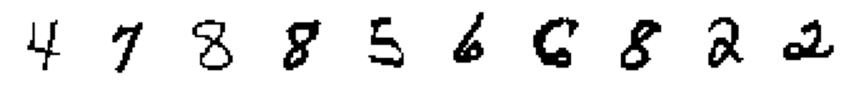

Reconstruction


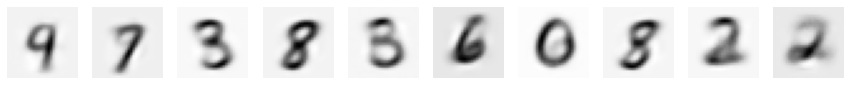

In [6]:
samples = dev_data_pixels[:10]

encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded = encoder(samples)
    reconstructed = decoder(encoded).detach().numpy()

print("Input")
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for i, (sample, ax) in enumerate(zip(samples, axes)):
    ax.axis("off")
    ax.imshow(sample.reshape((28, 28)), cmap='Greys')
plt.show()

print("Reconstruction")
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for i, (recons, ax) in enumerate(zip(reconstructed, axes)):
    ax.axis("off")
    ax.imshow(recons.reshape((28, 28)), cmap='Greys')
plt.show()

## Variational AutoEncoder


Variational Auto Encoder is a directed probabilistic graphical model (DPMG). Given the dataset $X = \{x^{(1)}, ..., x^{(N)}\}$, the network is trained to approximate the posterior distribution $q_{\phi}(z|x)$; $p_{\theta}(z)$ is the prior distribution of the latent variable $z$. The model should be trained in such a way to maximise the probability of observing a data that comes from the dataset distribution. Since the marginal likelihood is intractable, the objective function of a VAE is the variational lowerbound of the marginal likelihood of data.

The marginal likelihood for the set is the sum over the marginal likelihood of individual data points (from independence and logarithm properties):
$$
\log p_{\theta}(x^{(1)},\cdots,x^{(N)}) = \sum_{i=1}^{N}\log{p_{\theta}(x^{(i)})}.
$$
The likelihood $\log{p_{\theta}(x^{(i)})}$ is called an evidence. It is possible to derive its lower bound which equals:
$$
\log{p_{\theta}(x^{(i)})} \ge E_{q_{\phi}(z|x^{(i)})}\left[-\log q_{\phi(z|x)} + \log p_{\theta}(x|z)\right].
$$

It turns out that the gap between the evidence and the Using Evidence Lower BOund (ELBO) is the Kullback-Leibler divergence between $q_{\phi}(z∣x;θ)$ and $p_{\theta}(z)$. Given the above, the bjective can be rewritten as:
\begin{equation}
\begin{split}
\log p_{\theta}(x^{(i)}) &\ge L(\theta, \phi; x^{(i)}) \\
&= E_{q_{\phi}(z|x^{(i)})}\left[-\log q_{\phi(z|x)} + \log p_{\theta}(x|z)\right] \\
&= -D_{KL}\left(q_{\theta}(z|x^{(i)})||p_{\theta}(z)\right) + E_{q(z|x^{(i)})}\left[\log p_{\theta}(x|z)\right].
\end{split}
\end{equation}

KL divergence making posteriori and priori likelihoods to be similar and works as a regularization term. The expectation term will be responsible for minimising the reconstruction error. 

### VAE with continuous latent space and binary observed space

The first VAE is based on the following generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

where the latent random variable $Z$ takes value in $\mathbb R^n$.
The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent ($\mathcal{N}(0,1)$).
The conditional distribution $p(x | z ; \theta)$ is parameterized by a neural network.
The random variables $X$ are $m$ independent Bernoulli random variables.

#### KL Divergence Formula

The original KL divergence formula:
\begin{equation}
    KL(p(x)|q(x)) = \sum_{x \in X} p(x) \log(\frac{p(x)}{q(x)}).
\end{equation}

Here, a special case of variational inference has to be used. (https://en.wikipedia.org/wiki/Kullback–Leibler_divergence). KL divergence was implemented basing on the following formula:
\begin{equation}
    D_{KL} = - \frac{1}{2} \sum^{N}_{i=1} \left( 1 + \log{\sigma_{i}^2} - \mu_i^2 - \sigma^2_i \right).
\end{equation}

In [7]:
def KL_with_gaussian_prior(
    mu: torch.Tensor, log_sigma_squared: torch.Tensor,
) -> torch.Tensor:
    mu_squared = mu.pow(2)
    sigma_squared = log_sigma_squared.exp()
    return -0.5 * torch.sum(
        1 + log_sigma_squared - mu_squared - sigma_squared,
        axis=1,
    )

In [8]:
class GaussianEncoder(nn.Module):
    
    def __init__(
        self, 
        input_size: int,
        latent_size: int,
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Gaussian Encoder models a mapping from the dataset space 
        into latent space of the prior distribution parameters.
        
        Parameters:
        -----------
        input_size:
            Size of the input layer.
        latent_size:
            Size of the output vector.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        
        super(GaussianEncoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(input_size, latent_size)
            
        # Translate layer sizes into nn.Sequential model.
        layers = [input_size] + hidden_sizes
        self.network: nn.Sequential = build_model(layers, dropout=0.4)
        
        # Projection to compute mu from  the hidden state.
        self.proj_mu = nn.Linear(layers[-1], latent_size)
        # Projection to compute log_sigma_squared from the hidden state.
        self.proj_log_sigma_squared = nn.Linear(layers[-1], latent_size)
        
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        hid = self.network(batch)
        # Compute mu and log_sigma_squared form the hidden state.
        return self.proj_mu(hid), self.proj_log_sigma_squared(hid)

    
class GaussianDecoder(nn.Module):
    
    def __init__(
        self,
        output_size: int,
        latent_size: int,
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Gaussian Decoder models mapping from the latent vector
        into a vector from dataset space. This is a generative model
        capable of generating new images.
        
        Parameters:
        -----------
        output_size:
            Size of the output vector.
        latent_size:
            Size of the input layer.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        
        super(GaussianDecoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(output_size, latent_size)[::-1]
            
        # Translate layer sizes into nn.Sequential model.
        layers = [latent_size] + hidden_sizes + [output_size]
        self.network = build_model(layers, dropout=0.4)
        self.latent_size = latent_size
        
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        hid = self.network(batch)
        return hid
    
    def sample_distributions(self, n_samples: int) -> torch.Tensor:
        """Show sample distibution generated by the decoder."""
        # Sample n_samples latent vectors from the prior.
        z = torch.empty(n_samples, self.latent_size).normal_(mean=0, std=1)   
        # Pass the data through the decoder network.
        output = self(z)
        # Return conditional sample distribution.
        return torch.sigmoid(output)
         
    def sample_images(
            self, n_samples: int, argmax: bool = False) -> torch.Tensor:
        """Generate a number of images using the decoder."""
        # Compute the output distributions for each image.
        probs = self.sample_distributions(n_samples)

        if argmax:
            # Simply return most probable value.
            return 1 * (probs >= 0.5)
        
        # Sample from the output distribution.
        return torch.bernoulli(probs)

In [9]:
# Model hyperparameters.
input_dim = 28*28
latent_dim = 2
hidden_dims = [512, 256, 128]

# Training parameters.
n_epoch = 20
batch_dim = 256

encoder = GaussianEncoder(input_dim, latent_dim, hidden_dims)
decoder = GaussianDecoder(input_dim, latent_dim, hidden_dims[::-1])

# Adam optimizer, initialized with Encoder and Decoder parameters.
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4,
)

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        # Encoder inputs. Shape: (batch_dim, input_size)
        batch = train_data_pixels[i:i+batch_dim]
        
        # Compute parameters of the approximate posterior.
        # Shape: (batch_dim, latent_dim)
        mu, log_sigma_squared = encoder(batch)
        
        # Reparametrization trick ! 
        std = log_sigma_squared.mul(0.5).exp_()
        eps = torch.empty_like(mu).normal_(mean=0, std=1)
        # Latent vector. Shape: (batch_dim, latent_dim)
        z = eps.mul(std).add_(mu)
        
        # Reconstruction_logits: (batch_dim, input_size)
        # Here only one sample is drawn from the decoder.
        # For computing the reconstruction probability part
        # it's possible to draw more samples to get better
        # error estimation.
        reconstruction_logits = decoder(z)
        
        # Reconstruction error part of the ELBO. Shape: (batch_dim,)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        ).sum(1)
        
        # KL Divergence part of the ELBO. Shape: (batch_dim,)
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        
        # Loss shape: (batch dim,)
        elbo = -reconstruction_loss - kl_div
        
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # Mean loss over the batch.
        loss = -elbo.mean()
        loss.backward()
        
        # Optimization trick:
        # Gradient clipping limiting the updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(f"Epoch {epoch:2d}\t "
          f"rec_loss: {epoch_reconstruction / train_data_pixels.shape[0]:.8f}\t"
          f"kl_loss: {epoch_kl / train_data_pixels.shape[0]:.8f}")

Epoch  0	 rec_loss: -292.99754382	kl_loss: 3.84440066
Epoch  1	 rec_loss: -201.84805599	kl_loss: 1.92260849
Epoch  2	 rec_loss: -193.13167196	kl_loss: 2.28032452
Epoch  3	 rec_loss: -189.77107109	kl_loss: 2.33374262
Epoch  4	 rec_loss: -188.01595833	kl_loss: 2.37215430
Epoch  5	 rec_loss: -186.15652185	kl_loss: 2.55752412
Epoch  6	 rec_loss: -180.01816756	kl_loss: 3.42605818
Epoch  7	 rec_loss: -175.35497070	kl_loss: 3.90734743
Epoch  8	 rec_loss: -172.38974015	kl_loss: 4.18856444
Epoch  9	 rec_loss: -170.26435225	kl_loss: 4.32891475
Epoch 10	 rec_loss: -168.72536552	kl_loss: 4.43460545
Epoch 11	 rec_loss: -167.43754004	kl_loss: 4.52312481
Epoch 12	 rec_loss: -166.44109998	kl_loss: 4.58620153
Epoch 13	 rec_loss: -165.53327258	kl_loss: 4.64100792
Epoch 14	 rec_loss: -164.73556034	kl_loss: 4.70975216
Epoch 15	 rec_loss: -163.95967244	kl_loss: 4.75088212
Epoch 16	 rec_loss: -163.29471586	kl_loss: 4.82419991
Epoch 17	 rec_loss: -162.42505623	kl_loss: 4.87311138
Epoch 18	 rec_loss: -161.721

In [10]:
def sample_images(
    decoder: nn.Module, n_samples: int, argmax: bool = False,
) -> None:
    
    with torch.no_grad():
        samples = decoder.sample_images(n_samples, argmax=argmax)
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
    for i, (recons, ax) in enumerate(zip(samples, axes)):
        ax.axis("off")
        ax.imshow(recons.reshape((28, 28)), cmap='Greys')
    plt.show()
    
def sample_distributions(decoder: nn.Module, n_samples: int):
    with torch.no_grad():
        samples = decoder.sample_distributions(n_samples)
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
    for i, (recons, ax) in enumerate(zip(samples, axes)):
        ax.axis("off")
        ax.imshow(recons.reshape((28, 28)), cmap='Greys')
    plt.show()

Decoder Sampled Distributions


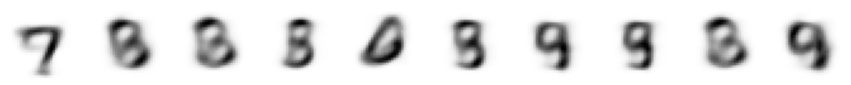

Decoder Sampled Images (argmax=False)


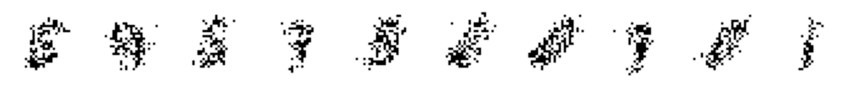

Decoder Sampled Images (argmax=True)


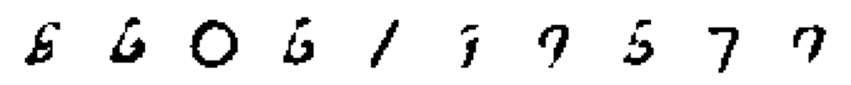

In [11]:
decoder.eval()
n_samples = 10

print("Decoder Sampled Distributions")
sample_distributions(decoder, n_samples)

print("Decoder Sampled Images (argmax=False)")
sample_images(decoder, n_samples, argmax=False)

print("Decoder Sampled Images (argmax=True)")
sample_images(decoder, n_samples, argmax=True)

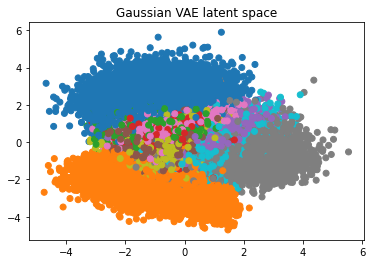

In [12]:
decoder.eval()

points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.title('Gaussian VAE latent space')
plt.show()

### VAE with binary latent space and binary observed space

The second VAE is based on the same generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

but where the latent variable $Z$ are independent Bernoulli random variables. The prior distribution is fixed as $Bernoulli(0.5)$.

### KL Divergence Formula
Assuming the prior of $Bernoulli(0.5)$ the KL divergence formula in this case would be different. Knowing the definition of KL divergence:
\begin{equation}
    KL(p(x)|q(x)) = \sum_{x \in X} p(x) log(\frac{p(x)}{q(x)}),
\end{equation}

where $p(x)$ is generated distribution and $q(x)$ is the prior, considering Bernoulli distribution where random variable take value either 0 or 1, the formula can be rewritten 
\begin{equation}
    KL(p(x)|q(x)) = \sum_{x \in \{0, 1\}} \Theta_{x} \log{\frac{\Theta_{x}}{0.5}} =
    \Theta_{0} \log {\frac{\Theta_{0}}{0.5}} + \Theta_{1}\log{\frac{\Theta_{1}}{0.5}}.
\end{equation}

Knowing that $\Theta_{1} = (1 - \Theta_{0})$:
\begin{equation}
\begin{split}
    KL(p(x)|q(x)) &= \Theta_{0} \log {\frac{\Theta_{0}}{0.5}} + (1- \Theta_{0})\log{\frac{(1-\Theta_{0})}{0.5}} \\
    &= \Theta_0 \log{\Theta_0} + (1-\Theta_{0})\log(1 - \Theta_0) - \Theta_0 \log{0.5} - (1-\Theta_{0})\log{0.5} \\
    &= \Theta_0 \log{\Theta_0} + (1-\Theta_{0})\log(0 - \Theta_0) - \log{0.5} \\
    &= -H(X) - \log{0.5}.
\end{split}
\end{equation}

Where $H(X)$ is entropy of Bernoulli distribution with parameter $\Theta_{0}$.

In [13]:
def KL_with_bernoulli_prior(probs: torch.Tensor) -> torch.Tensor:
    # KL divergence between generated dist and Bernoulli prior with p=0.5.
    entropy = torch.distributions.Bernoulli(probs).entropy()
    kl_div = -entropy - math.log(0.5)
    return torch.sum(kl_div, axis=1)

In [14]:
class BernoulliEncoder(nn.Module):

    def __init__(
        self,
        input_size: int,
        latent_size: int,
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Bernoulli Encoder capable of mapping the input 
        into a latent vector of Bernoulli distribution parameters.

        Parameters:
        -----------
        input_size:
            Size of the input layer.
        latent_size:
            Size of the output vector.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        super(BernoulliEncoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(input_size, latent_size)
            
        # Translate layer sizes into nn.Sequential model.
        layers = [input_size] + hidden_sizes + [latent_size]
        self.network: nn.Sequential = build_model(layers, dropout=0.5)
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        return self.network(batch)
    
class BernoulliDecoder(nn.Module):
    
    def __init__(
        self,
        output_size: int,
        latent_size: int,
        hidden_sizes: Optional[List[int]] = None,
    ) -> None:
        """Bernoulli Decoder capable of generating images taking 
        latent vector of Bernoulli variables as an input.

        Parameters:
        -----------
        output_size:
            Size of the output vector.
        latent_size:
            Size of the input layer.
        hidden_sizes:
            A list of hidden layers sizes. If not given 
            a funnel-like network will be generated.
        """
        
        super(BernoulliDecoder, self).__init__()
        
        if hidden_sizes is None:
            # If hidden dims are not given construct funnel-like 
            # network.
            hidden_sizes = get_funnel(output_size, latent_size)[::-1]
            
        # Translate layer sizes into nn.Sequential model.
        layers = [latent_size] + hidden_sizes + [output_size]
        self.network: nn.Sequential = build_model(layers, dropout=0.5)
        self.input_dim: int = latent_size
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Pass the data through the network."""
        return self.network(batch)
    
    def sample_distributions(self, n_samples: int) -> torch.Tensor:
        """Show sample distibution generated by the decoder."""
        # Sample from the prior distribution B(0.5)
        z = torch.ones(n_samples, self.input_dim).div_(2)
        # Sample from Bernoulli given the p.
        z = torch.bernoulli(z)
        return torch.sigmoid(self(z))
    
    def sample_images(
            self, n_samples: int, argmax: bool = False) -> torch.Tensor:
        """Generate a number of images using the decoder."""
        # Compute the output distributions for each image.
        probs = self.sample_distributions(n_samples)

        if argmax:
            # Simply return most probable value.
            return 1 * (probs >= 0.5)
        
        # Sample from the output distribution.
        return torch.bernoulli(probs)

In [15]:
# Model hyperparameters.
input_dim = 28*28
latent_dim = 16
hidden_dims = [512, 256,]
# Training parameters.
n_epoch = 30
batch_dim = 256

encoder = BernoulliEncoder(input_dim, latent_dim, hidden_dims)
decoder = BernoulliDecoder(input_dim, latent_dim, hidden_dims[::-1])

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-3,
)

running_avg = 0  # Running average to reduce variance
n_updates = 0
for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    
    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]
        
        # compute parameters of the approximate posterior
        mu = encoder(batch)
        
        # we get the parameter of bernoullis distribution by mapping the output it to a sigmoid.
        mu_bernoulli = torch.sigmoid(mu)
        
        # next we sample from bernoullis distributions
        z = torch.bernoulli(mu_bernoulli)
        
        # we obtain the reconstruction logits
        logits = decoder(z)
        
        # First create a term:
        log_p_x_given_z = -F.binary_cross_entropy_with_logits(
            logits, batch, reduction="none").sum(1)

        # then you can compute:
        log_q_z_give_x = -F.binary_cross_entropy(
            mu_bernoulli, z.detach(), reduction="none").sum(1)
        
        # now we substract the baseline C(x) to the log_q_z_give_x
        log_q_z_give_x_with_baseline = log_p_x_given_z.clone().detach() - running_avg

        # Then we compute the reconstruction_loss following the Score Function Estimator 
        reconstruction_loss = - log_p_x_given_z - log_q_z_give_x_with_baseline * log_q_z_give_x
        
        # Then we compute the Kullback-Leibler Divergence:
        kl_div = KL_with_bernoulli_prior(mu_bernoulli)
        
        # We accumulate both loss parameters 
        epoch_reconstruction += reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # We compute the loss:
        loss = reconstruction_loss + kl_div
        
        # We compute the negative loss to get maximization instead of minimization
        loss = loss.mean()
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        
        # update the running_avg
        n_updates += 1
        running_avg += (log_p_x_given_z.detach().mean().item() - running_avg) / n_updates

        
    print(f"Epoch {epoch:2d}\t "
          f"rec_loss: {epoch_reconstruction / train_data_pixels.shape[0]:.8f}\t"
          f"kl_loss: {epoch_kl / train_data_pixels.shape[0]:.8f}")

Epoch  0	 rec_loss: 703.44763363	kl_loss: 1.60554322
Epoch  1	 rec_loss: 414.38073877	kl_loss: 2.92914663
Epoch  2	 rec_loss: 338.93144124	kl_loss: 3.77994388
Epoch  3	 rec_loss: 319.68731209	kl_loss: 5.09739117
Epoch  4	 rec_loss: 293.74722762	kl_loss: 6.26763519
Epoch  5	 rec_loss: 276.76665780	kl_loss: 6.74192714
Epoch  6	 rec_loss: 250.23134652	kl_loss: 7.41871517
Epoch  7	 rec_loss: 242.17415755	kl_loss: 7.79720444
Epoch  8	 rec_loss: 225.48340747	kl_loss: 8.29653863
Epoch  9	 rec_loss: 207.35441630	kl_loss: 8.89730066
Epoch 10	 rec_loss: 197.77250509	kl_loss: 9.12730897
Epoch 11	 rec_loss: 186.51077173	kl_loss: 9.35540458
Epoch 12	 rec_loss: 182.16947640	kl_loss: 9.48186787
Epoch 13	 rec_loss: 180.73247355	kl_loss: 9.52114297
Epoch 14	 rec_loss: 173.59152555	kl_loss: 9.67767160
Epoch 15	 rec_loss: 168.97924019	kl_loss: 9.69790553
Epoch 16	 rec_loss: 165.52513786	kl_loss: 9.77443916
Epoch 17	 rec_loss: 164.87764954	kl_loss: 9.83197115
Epoch 18	 rec_loss: 161.60693868	kl_loss: 9.91

Decoder Sampled Distributions


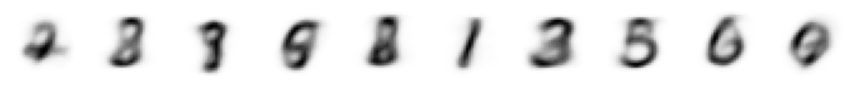

Decoder Sampled Images (argmax=False)


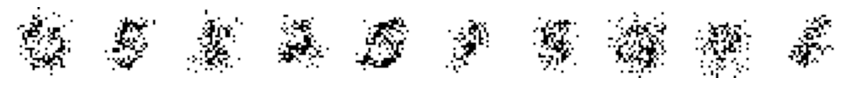

Decoder Sampled Images (argmax=True)


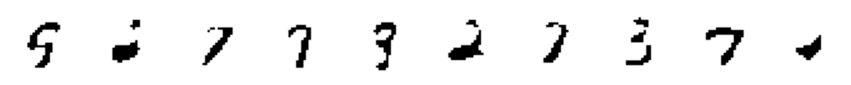

In [16]:
decoder.eval()
n_samples = 10

print("Decoder Sampled Distributions")
sample_distributions(decoder, n_samples)

print("Decoder Sampled Images (argmax=False)")
sample_images(decoder, n_samples, argmax=False)

print("Decoder Sampled Images (argmax=True)")
sample_images(decoder, n_samples, argmax=True)

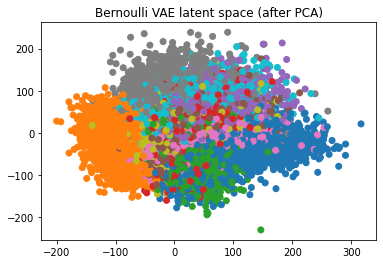

In [17]:
decoder.eval()

# tensor that will contain all latent points
points_latent = np.empty((train_data_pixels.shape[0], latent_dim))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        latent = encoder(batch)
        points_latent[i:i+batch_dim] = latent.numpy()

# Apply PCA to map latent space to 2D.
points = PCA(n_components=2).fit_transform(points_latent)
        
plt.scatter(
    points[:,0], points[:, 1],
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.title('Bernoulli VAE latent space (after PCA)')
plt.show()

## Using deterinistic AutoEncoder as a generative model.

Using the deterministic encoder and decoder models trained in the first section of this exercise it is possible to transform them into a generative model as well using a simple trick. The deterministic encoder learned to map samples from the dataset into a latent space. It is a deterministic mapping from $X$ to $Z$ space. Using the dataset mapped into the latten space, it is possible to train Gaussian Mixture Model that samples data which looks like the vectors coming from the latent space iself. Passing the sampled vector through decoder network should result in a generated sample coming from the dataset space. For simplicity the auto-encoder will be trained using $\mathbb R^2$ as latent space. 

In [26]:
# Model hyperparameters.
input_dim = 28*28
latent_dim = 2
hidden_dims = [512, 128,]

# Training parameters.
n_epoch = 20
batch_dim = 256

encoder = DeterministicEncoder(input_dim, latent_dim, hidden_dims)
decoder = DeterministicDecoder(input_dim, latent_dim, hidden_dims[::-1])

# Adam optimizer, initialized with Encoder and Decoder parameters.
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4,
)

encoder.train()
decoder.train()
for epoch in range(n_epoch):
    epoch_loss = 0
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        # Take a slice of the data samples.
        batch = train_data_pixels[i:i+batch_dim]

        optimizer.zero_grad()
        # Make pass through the network.
        encoded = encoder(batch)
        output = decoder(encoded)
        # Compute reconstruction loss.
        loss = F.mse_loss(output, batch)
        epoch_loss += loss.item()
        # Update model parameters.
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} loss: {epoch_loss:.4f} ...")

Epoch 0 loss: 18.3476 ...
Epoch 1 loss: 15.3216 ...
Epoch 2 loss: 14.5923 ...
Epoch 3 loss: 14.2053 ...
Epoch 4 loss: 13.9538 ...
Epoch 5 loss: 13.7924 ...
Epoch 6 loss: 13.6616 ...
Epoch 7 loss: 13.5466 ...
Epoch 8 loss: 13.4392 ...
Epoch 9 loss: 13.3359 ...
Epoch 10 loss: 13.2320 ...
Epoch 11 loss: 13.1480 ...
Epoch 12 loss: 13.0511 ...
Epoch 13 loss: 12.9746 ...
Epoch 14 loss: 12.8959 ...
Epoch 15 loss: 12.8446 ...
Epoch 16 loss: 12.7777 ...
Epoch 17 loss: 12.7195 ...
Epoch 18 loss: 12.6694 ...
Epoch 19 loss: 12.6149 ...


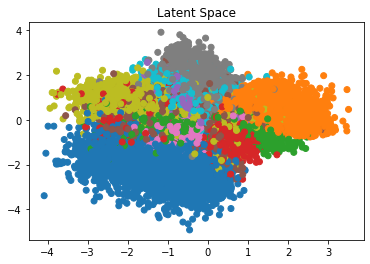

In [27]:
# Visualize AutoEncoder latent space.
decoder.eval()

points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        coords = encoder(batch)
        points[i:i+batch_dim] = coords.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.title('Latent Space')
plt.show()

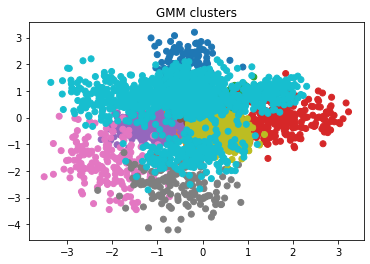

In [30]:
# Fit GMM to sample point from the latent space.
decoder.eval()

points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        coords = encoder(batch)
        points[i:i+batch_dim] = coords.numpy()
        
mixture = GaussianMixture(n_components=15)
mixture.fit(points)

mix_sample, cls = mixture.sample(5000)

plt.scatter(
    mix_sample[:,0], mix_sample[:, 1],
    c=matplotlib.cm.get_cmap("tab10")(cls / 10.)
)
plt.title('GMM clusters')
plt.show()

Generated samples


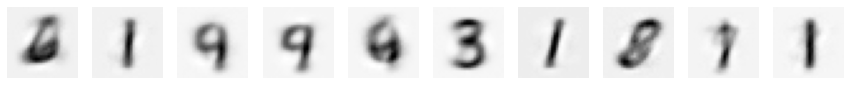

In [31]:
# Use GMM sampled latent vectors to generate new images.
decoder.eval()
n_samples = 10
with torch.no_grad():
    point, _ = mixture.sample(n_samples)
    z = torch.from_numpy(point).float()
    samples = decoder(z)
    
fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(15, 15))
for i, (recons, ax) in enumerate(zip(samples, axes)):
    ax.axis("off")
    ax.imshow(recons.reshape((28, 28)), cmap='Greys')
print("Generated samples")
plt.show()